# Particle Size Distribution
Notebook by Lukas Grünewald, [https://github.com/lukmuk/particle-size-distribution](https://github.com/lukmuk/particle-size-distribution).

Modified by Eric Leroy, [https://github.com/ricounet67](https://github.com/ricounet67) to generate reports for research purpose

## Purpose:
Evaluate (nano)particle (or other) size distribution by fitting a distribution function and extracting statistical parameters in Python.  
Requires `numpy`, `scipy`, and `pandas`. Additionally, the `uncertainties` [package](https://pythonhosted.org/uncertainties/) is used to handle uncertainty propagation.  

For the generation of the report [`ReportLab`](https://docs.reportlab.com/reportlab/userguide/ch1_intro/) and [`PyLaTeX`](https://jeltef.github.io/PyLaTeX/current/index.html) are also required.  

## Usage:
Segmentation and size measurements (e.g. areas, Feret diameters, ...) were extracted using *Fiji*.  
The `Results.csv` of the `Analyze particles...` function in *Fiji* is loaded here for analysis.  
Multiple `.csv` files can be loaded and stacked using `pandas`.  
To start, put the `.csv` files into the same folder with a copy of this notebook.

In the following example, the projected surface area of particles from an SEM image were measured in *Fiji* using [ParticleSizer](https://imagej.net/plugins/particlesizer).  
The **area-equivalent circle diameter** and the **minimum Feret diameters** are taken as exemplary size metrics and a log-normal distribution is fitted to the histograms.

Different figures are generated and table of the deciles of the distribution is also generated to create the final report. 

In [1]:
%matplotlib widget
%load_ext watermark

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob

# Fitting libraries
from scipy.optimize import curve_fit
from lmfit import models

# Pretty plots
import scienceplots

# For uncertainty propagation:
from uncertainties import ufloat, unumpy
from uncertainties.umath import *

In [3]:
#Print package versions
%watermark -d -v -u -m --iversions

Last updated: 2024-12-30

Python implementation: CPython
Python version       : 3.10.14
IPython version      : 8.27.0

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 24.2.0
Machine     : x86_64
Processor   : i386
CPU cores   : 16
Architecture: 64bit

numpy        : 1.26.4
uncertainties: 3.2.2
pandas       : 2.2.2
scienceplots : 2.1.1
scipy        : 1.14.1
lmfit        : 1.3.2
matplotlib   : 3.9.2



In [4]:
plt.style.use(['science','notebook'])

### Define a particle size distribution  
Here, we use a log-normal distribution (or probability density function, PDF) as an example.  
I tested other variants such as using [scipy.stats.lognorm](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.lognorm.html) but the following approach gave me best results and easy access to the statistical fitting errors.

At the end of the notebook there is an approach using an `lmfit` model ([https://github.com/lmfit/lmfit-py](https://github.com/lmfit/lmfit-py)).  
This is convenient to use since the `uncertainties` package was included directly into `lmfit` and the uncertainties and correlations are conveniently handled during fitting.

In [5]:
def pdf(x, mu, sigma):
    """Probability density function of a log-normal distribution"""
    return (np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2)) / (x * sigma * np.sqrt(2 * np.pi)))

For a nice discussion about the [log-normal distribution](https://en.wikipedia.org/wiki/Log-normal_distribution) in this context, see  
E. Limpert, W. A. Stahel, and M. Abbt, *BioScience*, **51**, 5,(2001) 341–352, doi: [10.1641/0006-3568(2001)051](https://doi.org/10.1641/0006-3568(2001)051[0341:LNDATS]2.0.CO;2). The above definition is

$$    {\displaystyle f(x)={\frac {1}{{\sqrt {2\pi }}\sigma x}}\,\exp {\Big (}-{\frac {(\ln(x)-\mu )^{2}}{2\sigma ^{2}}}{\Big )},\quad x>0}$$
with the mean $\mu$ and standard deviation $\sigma$ of $\ln(x)$ as fit parameters.  
Note, that here we don't scale the amplitude and assume a normalized histogram, whereas the `lmfit` package by default initialize a prefactor that is used during fitting (it can be fixed to 1 as well).

### Properties for the log-normal distribution 
We calculate the mode $M$, median $m$, arithmetic mean $\mu_\text{a}$, and standard deviation $\sigma_\text{a}$ for the measured values $x$ from the fitted $\mu$ and $\sigma$ parameters.  
Statistical fitting errors on $\mu$ and $\sigma$ will be propagated by the ``uncertainties`` [package](https://pythonhosted.org/uncertainties/).
$$M(x)=e^{\mu -\sigma ^{2}}$$
$$m(x)=e^{\mu}$$
$$\mu_\text{a}(x)=e^{\mu + \frac{\sigma ^{2}}{2}}$$
$$\sigma_\text{a}(x)=e^{\mu +{\tfrac {1}{2}}\sigma ^{2}}{\sqrt {e^{\sigma ^{2}}-1}}$$

#### Scatter intervals

For a log-normal distribution, with geometric mean and standard deviation $\mu^{∗}=e^\mu$ and $\sigma^{∗} = e^\sigma$, 
$$[ \mu^{∗}/ \sigma^{∗} , \mu^{∗}\cdot\sigma^{∗} ]$$
contains 68 %, and 
$$[ \mu^{∗}/ \left(\sigma^{∗}\right)^2 , \mu^{∗}\cdot\left(\sigma^{∗}\right)^2 ]$$ 
contains 95 % of the probability.

## Load and inspect data

Load the data:

Ici on entre les valeurs spécifiques à notre manip

In [6]:
titre='Film OAMi941'
unit='$\mu$m'

In [7]:
# Grab and stack all csv files in working directory in a pandas data frame
df = pd.concat([pd.read_csv(filename, header=0, index_col=None) for filename in glob.glob('*.csv')], ignore_index=True)

In [8]:
df.shape

(715, 19)

In [9]:
print(f'Number of measured particles/grains: {df.shape[0]}')

Number of measured particles/grains: 715


In [10]:
# Inspect data set
df.head()

,,Area,Perim.,BX,BY,Width,Height,Major,Minor,Angle,Circ.,Feret,FeretX,FeretY,FeretAngle,MinFeret,AR,Round,Solidity
0,1,0.156,1.425,48.939,1.489,0.465,0.465,0.448,0.443,146.310,0.965,0.543,527,16,120.964,0.465,1.013,0.987,0.857
1,2,0.208,1.611,82.992,1.954,0.465,0.558,0.580,0.456,125.291,1.000,0.671,892,21,123.690,0.465,1.272,0.786,0.906
2,3,1.065,3.857,52.382,2.605,1.210,1.210,1.192,1.138,98.128,0.899,1.296,568,41,68.962,1.196,1.048,0.954,0.904
3,4,0.268,1.797,40.007,3.629,0.651,0.465,0.685,0.499,0.000,1.000,0.709,430,40,156.801,0.465,1.372,0.729,0.939
4,5,0.156,1.348,54.987,4.373,0.465,0.372,0.491,0.404,0.000,1.000,0.543,591,47,149.036,0.372,1.218,0.821,0.947


### Metric: Area-Equivalent Circle Diameter
An often used metric is the area-equivalent circle diameter.  
We calculate circles with equal size as the measured projected particle/grain size (``Area`` column).

In [11]:
data = df['Area'].to_numpy()

Calcule les 10 centiles de la distribution des aires

In [52]:
Area_centiles = np.quantile(data,np.arange(0,1,.1))
Area_centiles

array([0.10704745, 0.31513915, 0.49184908, 0.64722161, 0.77849985,
       0.9034083 , 1.06031623, 1.21530156, 1.41610462, 1.64990489])

Calculate area-equivalent diameters from areas: $${\displaystyle d_{p}={\sqrt {\frac {4A}{\pi }}}.}$$

In [54]:
data = np.sqrt(4*data/np.pi)

In [55]:
Dp_centiles = np.quantile(data,np.arange(0,1,.1))
Dp_centiles

array([0.36918429, 0.6334411 , 0.79135434, 0.90778199, 0.99559871,
       1.07249949, 1.16191074, 1.24393328, 1.3427734 , 1.44938751])

### Génération du tableau des déciles et export en pdf et LaTeX

* en utilisant le package ReportLab https://docs.reportlab.com/reportlab/userguide/ch1_intro/

In [78]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from reportlab.lib import colors
from reportlab.lib.pagesizes import letter
from reportlab.lib.pagesizes import A4  # Import de la taille de page A4
from reportlab.platypus import SimpleDocTemplate, Table, TableStyle

# Création du DataFrame
df = pd.DataFrame({
    'Centile': [f"$d_{{{int(i*10)}}}$" for i in range(1,11 )],  # Noms des centiles
    'Area ('+unit+')': Area_centiles,
    'Area-equivalent diameter ('+unit+')': Dp_centiles
})
# Formatage des valeurs avec deux chiffres après la virgule
df['Area ('+unit+')'] = df['Area ('+unit+')'].apply(lambda x: f"{x:.2f}")
df['Area-equivalent diameter ('+unit+')'] = df['Area-equivalent diameter ('+unit+')'].apply(lambda x: f"{x:.2f}")

# Création du tableau avec Matplotlib
def save_table_as_pdf(dataframe, filename):
    fig, ax = plt.subplots(figsize=(8, 4))  # Taille de la figure
    ax.axis('tight')
    ax.axis('off')

    # Création du tableau
    table = ax.table(
        cellText=dataframe.values,
        colLabels=dataframe.columns,
        cellLoc='center',
        loc='center'
    )

    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.auto_set_column_width(col=list(range(len(dataframe.columns))))

    # Sauvegarde en PDF
    with PdfPages(filename) as pdf:
        pdf.savefig(fig, bbox_inches='tight')
    plt.close(fig)

# Sauvegarde du tableau dans un fichier PDF
save_table_as_pdf(df, "tableau-"+titre+".pdf")
print("Tableau enregistré dans 'tableau-"+titre+".pdf'")

# Conversion du DataFrame en liste de listes
data = [df.columns.to_list()] + df.values.tolist()

# Fonction pour créer un PDF avec ReportLab
def save_table_as_pdf(data, filename):
    # Création du document PDF
    pdf = SimpleDocTemplate(filename, pagesize=A4)
    elements = []

    # Création de la table
    table = Table(data)
    
    # Style de la table
    style = TableStyle([
        ('BACKGROUND', (0, 0), (-1, 0), colors.grey),  # En-tête grisée
        ('TEXTCOLOR', (0, 0), (-1, 0), colors.whitesmoke),  # Texte en blanc pour l'en-tête
        ('ALIGN', (0, 0), (-1, -1), 'CENTER'),  # Alignement centré
        ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),  # Police de l'en-tête
        ('BOTTOMPADDING', (0, 0), (-1, 0), 12),  # Padding en bas de l'en-tête
        ('BACKGROUND', (0, 1), (-1, -1), colors.beige),  # Fond beige pour les cellules
        ('GRID', (0, 0), (-1, -1), 1, colors.black)  # Grille noire
    ])
    table.setStyle(style)

    # Ajout de la table aux éléments du PDF
    elements.append(table)

    # Génération du PDF
    pdf.build(elements)

# Fonction pour sauvegarder le tableau en LaTeX
def save_table_as_latex(data, filename):
    headers = " & ".join(data[0]) + " \\\\\n\\hline\n"
    rows = "\n".join([" & ".join(map(str, row)) + " \\\\" for row in data[1:]])
    latex_table = f"""
\\documentclass[a4paper]{{article}}
\\usepackage[utf8]{{inputenc}}
\\usepackage{{amsmath}}
\\usepackage{{array}}
\\begin{{document}}

\\section*{{Tableau des Données}}
\\begin{{table}}[h!]
\\centering
\\begin{{tabular}}{{|{'c|' * len(data[0])}}}
\\hline
{headers}
{rows}
\\hline
\\end{{tabular}}
\\caption{{Tableau généré à partir des données.}}
\\end{{table}}

\\end{{document}}
"""
    with open(filename, "w", encoding="utf-8") as f:
        f.write(latex_table)

# Sauvegarde du tableau dans un fichier PDF
save_table_as_pdf(data, "tableau_reportlab_latex-"+titre+".pdf")
save_table_as_latex(data, "tableau_latex-"+titre+".tex")


Tableau enregistré dans 'tableau-Film OAMi941.pdf'


* en utilisant le package PyLaTeX https://jeltef.github.io/PyLaTeX/current/index.html

In [81]:
from pylatex import Document, Section, Table, Tabular, Package
# Fonction pour générer un document LaTeX avec PyLaTeX
def generate_latex_with_pylatex(df, filename):
    # Initialisation du document
    doc = Document(documentclass="article", document_options="a4paper")
    doc.packages.append(Package("amsmath"))
    doc.packages.append(Package("array"))

    # Ajouter une section et un tableau
    with doc.create(Section("Tableau des Données")):
        with doc.create(Table(position="h!")) as table:
            table.add_caption("Tableau généré à partir des données.")
            with doc.create(Tabular("|c|c|c|")) as tabular:
                # Ajouter les en-têtes
                tabular.add_hline()
                tabular.add_row(df.columns)
                tabular.add_hline()
                # Ajouter les données
                for _, row in df.iterrows():
                    tabular.add_row(row)
                tabular.add_hline()

    # Sauvegarde et compilation en PDF
    doc.generate_pdf(filename, clean_tex=False)
    print(f"Fichier PDF généré : {filename}.pdf")
    print(f"Fichier source LaTeX généré : {filename}.tex")

# Sauvegarde et compilation
generate_latex_with_pylatex(df, "tableau_pylatex")

Fichier PDF généré : tableau_pylatex.pdf
Fichier source LaTeX généré : tableau_pylatex.tex


The next cell, plots the histogram, performs a fit of the (log-normal) distribution, and displays/saves the result.  

/var/folders/1n/ghmw9sj13m3428cl4z3_x0bm0000gn/T/ipykernel_9787/2567239602.py:3: RuntimeWarning: invalid value encountered in log
  return (np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2)) / (x * sigma * np.sqrt(2 * np.pi)))


Mode:		 0.59+/-0.04
Median:		 0.95+/-0.04
Mean:		 1.21+/-0.06
Std. dev.:	 0.95+/-0.10
68% conf. intervall: 0.0+/-0.0 to 2.0+/-0.0
95% conf. intervall: 0.0+/-0.0 to 4.0+/-0.0


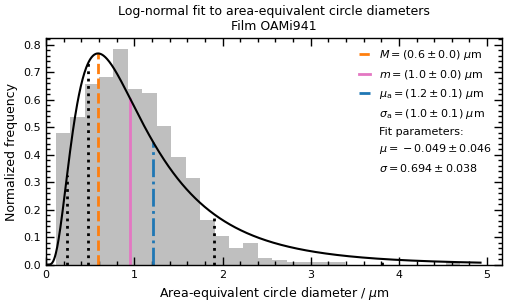

In [16]:
# Create plot
fig, ax = plt.subplots(figsize=(5, 3))

# Normalized histogram
n, bins, patches = ax.hist(data, bins='auto', density=True, facecolor = 'grey', alpha = 0.5, label=None)
centers = (0.5*(bins[1:]+bins[:-1]))

# Fit of pdf
pars, cov = curve_fit(pdf, centers, n)

# Draw pdf
pdfcol ='k'
xmin, xmax = ax.get_xlim()
x = np.linspace(xmin, xmax, 1000)
ax.plot(x, pdf(x, *pars), pdfcol , linewidth = 1.5, label=None, zorder=10)

# Add fit parameters (mu, sigma, mode) as labels
# Errors are from diagonal elements of cov (covariance matrix) --> sqrt(Var)=Std dev
mu, sigma = unumpy.uarray(pars, np.sqrt(np.diag(cov)))

muStar = exp(mu)
sigStar = exp(sigma)
confidence68 = (muStar/sigStar, muStar*sigStar) 
confidence95 = (muStar/sigStar**2, muStar*sigStar**2) 

mode = exp(mu - sigma ** 2)
median = exp(mu)
mean = exp(mu + sigma ** 2 / 2)
std = exp(mu + sigma**2/2) * sqrt(exp(sigma**2)-1)

print(f'Mode:\t\t {mode}')
print(f'Median:\t\t {median}')
print(f'Mean:\t\t {mean}')
print(f'Std. dev.:\t {std}')
print(f'68% conf. intervall: {np.round(confidence68[0].nominal_value)}+/-{np.round(confidence68[0].std_dev)} to {np.round(confidence68[1].nominal_value)}+/-{np.round(confidence68[1].std_dev)}')
print(f'95% conf. intervall: {np.round(confidence95[0].nominal_value)}+/-{np.round(confidence95[0].std_dev)} to {np.round(confidence95[1].nominal_value)}+/-{np.round(confidence95[1].std_dev)}')

# Plot labels
lb_std = rf'$\sigma_\mathregular{{a}} = ({np.round(std.nominal_value,1)} \pm {np.round(std.std_dev,1)})$ $\mu$m'
lb_mean = rf'$\mu_\mathregular{{a}} = ({np.round(mean.nominal_value,1)} \pm {np.round(mean.std_dev,1)})$ $\mu$m'
lb_mode = rf'$M = ({np.round(mode.nominal_value,1)} \pm {np.round(mode.std_dev,1)})$ $\mu$m'
lb_median = rf'$m = ({np.round(median.nominal_value,1)} \pm {np.round(median.std_dev,1)})$ $\mu$m'
lb_mu = f'$\mu = {np.round(mu.nominal_value,3)} \pm {np.round(mu.std_dev,3)}$'
lb_sig = f'$\sigma = {np.round(sigma.nominal_value,3)} \pm {np.round(sigma.std_dev,3)}$'

# Add vertical markers for positions of calculated properties
# Mode
ax.plot([mode.nominal_value, mode.nominal_value], [0, pdf(mode.nominal_value, *pars)], c='tab:orange', ls='--', label=lb_mode)

# Median
ax.plot([median.nominal_value, median.nominal_value], [0, pdf(median.nominal_value, *pars)], c='tab:pink', ls='-', label=lb_median)

# Mean
ax.plot([mean.nominal_value, mean.nominal_value], [0, pdf(mean.nominal_value, *pars)], c='tab:blue', ls='-.', label=lb_mean)

# Confidence intervall 68%
ci = confidence68
ax.plot([ci[0].nominal_value, ci[0].nominal_value], [0, pdf(ci[0].nominal_value, *pars)], c=pdfcol, ls='dotted')
ax.plot([ci[1].nominal_value, ci[1].nominal_value], [0, pdf(ci[1].nominal_value, *pars)], c=pdfcol, ls='dotted')

# Confidence intervall 95%
ci = confidence95
ax.plot([ci[0].nominal_value, ci[0].nominal_value], [0, pdf(ci[0].nominal_value, *pars)], c=pdfcol, ls='dotted')
ax.plot([ci[1].nominal_value, ci[1].nominal_value], [0, pdf(ci[1].nominal_value, *pars)], c=pdfcol, ls='dotted')

# Gemerate empty plots, so that fit parameters are added in legend
plt.plot([], [], ' ', label=lb_std)
plt.plot([], [], ' ', label='Fit parameters:')
plt.plot([], [], ' ', label=lb_mu)
plt.plot([], [], ' ', label=lb_sig)

# Cosmetics 
ax.set_title('Log-normal fit to area-equivalent circle diameters\n'+titre, fontsize=9)
ax.set_xlabel('Area-equivalent circle diameter / $\mu$m', fontsize=9)
ax.set_ylabel("Normalized frequency", fontsize=9)
plt.tick_params(axis='both', which='major', labelsize=8)

ax.set_xlim(0,)
#ax.set_ylim(0, np.max(pdf(x, *pars))*1.8)

ax.legend(loc='best', handlelength=1, fontsize=8, ncol=1, columnspacing=0.1)
plt.tight_layout(pad=0.1)
fig.savefig('plots/AreaEquivalentCircleDiameter_normalized.pdf', pad_inches=0)

### Metric:  Area-equivalent Diameter

In [130]:
# On peut vouloir travailler sur le diamètre de Feret
# dans ce cas on utilise les valeurs de MinFeret
# data = df['MinFeret'].to_numpy()

/var/folders/1n/ghmw9sj13m3428cl4z3_x0bm0000gn/T/ipykernel_9787/2567239602.py:3: RuntimeWarning: invalid value encountered in log
  return (np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2)) / (x * sigma * np.sqrt(2 * np.pi)))


Mode:		 0.59+/-0.04
Median:		 0.95+/-0.04
Mean:		 1.21+/-0.06
Std. dev.:	 0.95+/-0.10
68% conf. intervall: 0.0+/-0.0 to 2.0+/-0.0
95% conf. intervall: 0.0+/-0.0 to 4.0+/-0.0


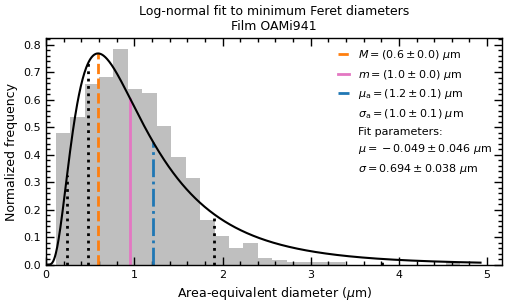

In [21]:
# Create plot
fig, ax = plt.subplots(figsize=(5, 3))

# Normalized histogram
n, bins, patches = ax.hist(data, bins='auto', density=True, facecolor = 'grey', alpha = 0.5, label=None)
centers = (0.5*(bins[1:]+bins[:-1]))

# Fit of pdf
pars, cov = curve_fit(pdf, centers, n)

# Draw pdf
pdfcol ='k'
xmin, xmax = ax.get_xlim()
x = np.linspace(xmin, xmax, 1000)
ax.plot(x, pdf(x, *pars), pdfcol , linewidth = 1.5, label=None, zorder=10)

# Add fit parameters (mu, sigma, mode) as labels
# Errors are from diagonal elements of cov (covariance matrix) --> sqrt(Var)=Std dev
mu, sigma = unumpy.uarray(pars, np.sqrt(np.diag(cov)))

muStar = exp(mu)
sigStar = exp(sigma)
confidence68 = (muStar/sigStar, muStar*sigStar) 
confidence95 = (muStar/sigStar**2, muStar*sigStar**2) 

mode = exp(mu - sigma ** 2)
median = exp(mu)
mean = exp(mu + sigma ** 2 / 2)
std = exp(mu + sigma**2/2) * sqrt(exp(sigma**2)-1)

print(f'Mode:\t\t {mode}')
print(f'Median:\t\t {median}')
print(f'Mean:\t\t {mean}')
print(f'Std. dev.:\t {std}')
print(f'68% conf. intervall: {np.round(confidence68[0].nominal_value)}+/-{np.round(confidence68[0].std_dev)} to {np.round(confidence68[1].nominal_value)}+/-{np.round(confidence68[1].std_dev)}')
print(f'95% conf. intervall: {np.round(confidence95[0].nominal_value)}+/-{np.round(confidence95[0].std_dev)} to {np.round(confidence95[1].nominal_value)}+/-{np.round(confidence95[1].std_dev)}')

# Plot labels
lb_std = rf'$\sigma_\mathregular{{a}} = ({np.round(std.nominal_value,1)} \pm {np.round(std.std_dev,1)})$ '+unit
lb_mean = rf'$\mu_\mathregular{{a}} = ({np.round(mean.nominal_value,1)} \pm {np.round(mean.std_dev,1)})$ '+unit
lb_mode = rf'$M = ({np.round(mode.nominal_value,1)} \pm {np.round(mode.std_dev,1)})$ '+unit
lb_median = rf'$m = ({np.round(median.nominal_value,1)} \pm {np.round(median.std_dev,1)})$ '+unit
lb_mu = f'$\mu = {np.round(mu.nominal_value,3)} \pm {np.round(mu.std_dev,3)}$'
lb_sig = f'$\sigma = {np.round(sigma.nominal_value,3)} \pm {np.round(sigma.std_dev,3)}$'

# Add vertical markers for positions of calculated properties
# Mode
ax.plot([mode.nominal_value, mode.nominal_value], [0, pdf(mode.nominal_value, *pars)], c='tab:orange', ls='--', label=lb_mode)

# Median
ax.plot([median.nominal_value, median.nominal_value], [0, pdf(median.nominal_value, *pars)], c='tab:pink', ls='-', label=lb_median)

# Mean
ax.plot([mean.nominal_value, mean.nominal_value], [0, pdf(mean.nominal_value, *pars)], c='tab:blue', ls='-.', label=lb_mean)

# Confidence intervall 68%
ci = confidence68
ax.plot([ci[0].nominal_value, ci[0].nominal_value], [0, pdf(ci[0].nominal_value, *pars)], c=pdfcol, ls='dotted')
ax.plot([ci[1].nominal_value, ci[1].nominal_value], [0, pdf(ci[1].nominal_value, *pars)], c=pdfcol, ls='dotted')

# Confidence intervall 95%
ci = confidence95
ax.plot([ci[0].nominal_value, ci[0].nominal_value], [0, pdf(ci[0].nominal_value, *pars)], c=pdfcol, ls='dotted')
ax.plot([ci[1].nominal_value, ci[1].nominal_value], [0, pdf(ci[1].nominal_value, *pars)], c=pdfcol, ls='dotted')

# Gemerate empty plots, so that fit parameters are added in legend
plt.plot([], [], ' ', label=lb_std)
plt.plot([], [], ' ', label='Fit parameters:')
plt.plot([], [], ' ', label=lb_mu+' '+unit)
plt.plot([], [], ' ', label=lb_sig+' '+unit)

# Cosmetics 
ax.set_title('Log-normal fit to minimum Feret diameters\n'+titre, fontsize=9)
ax.set_xlabel('Area-equivalent diameter ('+unit+')', fontsize=9)
ax.set_ylabel("Normalized frequency", fontsize=9)
plt.tick_params(axis='both', which='major', labelsize=8)

ax.set_xlim(0,)
#ax.set_ylim(0, np.max(pdf(x, *pars))*1.8)

ax.legend(loc='best', handlelength=1, fontsize=8, ncol=1, columnspacing=0.1)
plt.tight_layout(pad=0.1)
fig.savefig('plots/Area-equivalentDiameter_normalized.pdf', pad_inches=0)

### Plot with absolute values on $y$-axis instead of normalized values  
The above distributions show the normalized histograms (`density=True` keyword) and the fraction on the $y$ axis.  
Alternatively, the absolute values (the actual number of counted grains/particles in the histogram bins) can also be displayed.  
This is done by  
  - Fitting the distribution to the normalized values (then we do not need to fit a scaling factor as another fit parameter)
  - Plotting the histogram with absolute frequencies (`density=False`)
  - Use a scaling factor to scale up the fitted distribution (taken from [here](https://stackoverflow.com/questions/41024455/histogram-with-non-normalized-fit-line-matplotlib))

/var/folders/1n/ghmw9sj13m3428cl4z3_x0bm0000gn/T/ipykernel_9787/2567239602.py:3: RuntimeWarning: invalid value encountered in log
  return (np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2)) / (x * sigma * np.sqrt(2 * np.pi)))


Mode:		 0.59+/-0.04
Median:		 0.95+/-0.04
Mean:		 1.21+/-0.06
Std. dev.:	 0.95+/-0.10
68% conf. intervall: 0.0+/-0.0 to 2.0+/-0.0
95% conf. intervall: 0.0+/-0.0 to 4.0+/-0.0


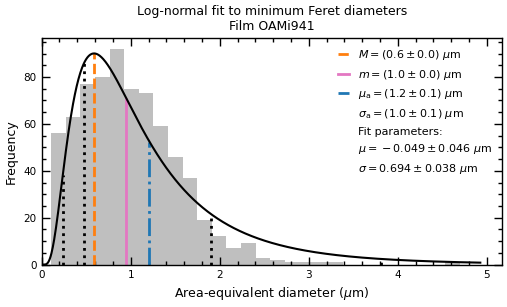

In [25]:
# Create plot
fig, ax = plt.subplots(figsize=(5, 3))

# Fit distribution using normalized histogram
n2, bins2, patches2 = ax.hist(data, bins='auto', density=True, facecolor = 'grey', alpha = 0, label=None)
centers2 = (0.5*(bins[1:]+bins[:-1]))
pars, cov = curve_fit(pdf, centers2, n2)

# Plot histogram with absolute values, i.e. density=False
n, bins, patches = ax.hist(data, bins='auto', density=False, facecolor = 'grey', alpha = 0.5, label=None)
centers = (0.5*(bins[1:]+bins[:-1]))

# Scaling factor for distribution
# https://stackoverflow.com/questions/41024455/histogram-with-non-normalized-fit-line-matplotlib
scaling_factor = sum(n * np.diff(bins))

# Draw pdf
pdfcol ='k'
xmin, xmax = ax.get_xlim()
x = np.linspace(xmin, xmax, 1000)
ax.plot(x, pdf(x, *pars)*scaling_factor, pdfcol, linewidth = 1.5, label=None, zorder=100)

# Add fit parameters (mu, sigma, mode) as labels
# Errors are from diagonal elements of cov (covariance matrix) --> sqrt(Var)=Std dev
mu, sigma = unumpy.uarray(pars, np.sqrt(np.diag(cov)))

muStar = exp(mu)
sigStar = exp(sigma)
confidence68 = (muStar/sigStar, muStar*sigStar) 
confidence95 = (muStar/sigStar**2, muStar*sigStar**2) 

mode = exp(mu - sigma ** 2)
median = exp(mu)
mean = exp(mu + sigma ** 2 / 2)
std = exp(mu + sigma**2/2) * sqrt(exp(sigma**2)-1)

print(f'Mode:\t\t {mode}')
print(f'Median:\t\t {median}')
print(f'Mean:\t\t {mean}')
print(f'Std. dev.:\t {std}')
print(f'68% conf. intervall: {np.round(confidence68[0].nominal_value)}+/-{np.round(confidence68[0].std_dev)} to {np.round(confidence68[1].nominal_value)}+/-{np.round(confidence68[1].std_dev)}')
print(f'95% conf. intervall: {np.round(confidence95[0].nominal_value)}+/-{np.round(confidence95[0].std_dev)} to {np.round(confidence95[1].nominal_value)}+/-{np.round(confidence95[1].std_dev)}')

# Plot labels
lb_std = rf'$\sigma_\mathregular{{a}} = ({np.round(std.nominal_value,1)} \pm {np.round(std.std_dev,1)})$ '+unit
lb_mean = rf'$\mu_\mathregular{{a}} = ({np.round(mean.nominal_value,1)} \pm {np.round(mean.std_dev,1)})$ '+unit
lb_mode = rf'$M = ({np.round(mode.nominal_value,1)} \pm {np.round(mode.std_dev,1)})$ '+unit
lb_median = rf'$m = ({np.round(median.nominal_value,1)} \pm {np.round(median.std_dev,1)})$ '+unit
lb_mu = f'$\mu = {np.round(mu.nominal_value,3)} \pm {np.round(mu.std_dev,3)}$ '+unit
lb_sig = f'$\sigma = {np.round(sigma.nominal_value,3)} \pm {np.round(sigma.std_dev,3)}$ '+unit

# Add vertical markers for positions of calculated properties
# Mode
ax.plot([mode.nominal_value, mode.nominal_value], [0, pdf(mode.nominal_value, *pars)*scaling_factor], c='tab:orange', ls='--', label=lb_mode)

# Median
ax.plot([median.nominal_value, median.nominal_value], [0, pdf(median.nominal_value, *pars)*scaling_factor], c='tab:pink', ls='-', label=lb_median)

# Mean
ax.plot([mean.nominal_value, mean.nominal_value], [0, pdf(mean.nominal_value, *pars)*scaling_factor], c='tab:blue', ls='-.', label=lb_mean)

# Confidence intervall 68%
ci = confidence68
ax.plot([ci[0].nominal_value, ci[0].nominal_value], [0, pdf(ci[0].nominal_value, *pars)*scaling_factor], c=pdfcol, ls='dotted')
ax.plot([ci[1].nominal_value, ci[1].nominal_value], [0, pdf(ci[1].nominal_value, *pars)*scaling_factor], c=pdfcol, ls='dotted')

# Confidence intervall 95%
ci = confidence95
ax.plot([ci[0].nominal_value, ci[0].nominal_value], [0, pdf(ci[0].nominal_value, *pars)*scaling_factor], c=pdfcol, ls='dotted')
ax.plot([ci[1].nominal_value, ci[1].nominal_value], [0, pdf(ci[1].nominal_value, *pars)*scaling_factor], c=pdfcol, ls='dotted')

# Gemerate empty plots, so that fit parameters are added in legend
plt.plot([], [], ' ', label=lb_std)
plt.plot([], [], ' ', label='Fit parameters:')
plt.plot([], [], ' ', label=lb_mu)
plt.plot([], [], ' ', label=lb_sig)

# Cosmetics 
ax.set_title(f'Log-normal fit to minimum Feret diameters\n'+titre, fontsize=9)
ax.set_xlabel('Area-equivalent diameter ('+unit+')', fontsize=9)
ax.set_ylabel("Frequency", fontsize=9)
plt.tick_params(axis='both', which='major', labelsize=7.5)

ax.set_xlim(0,)
#ax.set_ylim(0, np.max(pdf(x, *pars))*1.8)

ax.legend(loc='best', handlelength=1, fontsize=8, ncol=1, columnspacing=0.1)
plt.tight_layout(pad=0.1)
fig.savefig('plots/Area-equivalent_absolute.pdf', pad_inches=0)
fig.savefig('plots/Area-equivalent_absolute.png', dpi=600, pad_inches=0)

# Using `lmfit` package
Use the built-in `LognormalModel` from the `lmfit` package ([https://lmfit.github.io/lmfit-py/builtin_models.html#lognormalmodel](https://lmfit.github.io/lmfit-py/builtin_models.html#lognormalmodel)).

In [27]:
from lmfit import models

In [28]:
model = models.LognormalModel()

In [29]:
# Normalize histogram True/False
# Changes the values on the y axis from absolute to normalized values
normalize_histogram = False

[[Model]]
    Model(lognormal)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 82
    # data points      = 28
    # variables        = 3
    chi-square         = 2454.96001
    reduced chi-square = 98.1984004
    Akaike info crit   = 131.262515
    Bayesian info crit = 135.259128
    R-squared          = 0.91298468
[[Variables]]
    amplitude:  126.880777 +/- 8.63215752 (6.80%) (init = 1)
    center:    -0.01568140 +/- 0.06082410 (387.87%) (init = 1)
    sigma:      0.73034153 +/- 0.04839926 (6.63%) (init = 1)
    height:     91.9213324 +/- 5.39177371 (5.87%) == 'amplitude/max(1e-15, (sigma*sqrt(2*pi)))*exp(sigma**2/2-center)'
    fwhm:       1.12016938 +/- 0.07626482 (6.81%) == 'exp(center-sigma**2+sigma*sqrt(2*log(2)))-exp(center-sigma**2-sigma*sqrt(2*log(2)))'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, center) = +0.6607
    C(amplitude, sigma)  = +0.6238
    C(center, sigma)     = +0.5979
Mode:		 0.577+/-0.034
Median:		 0.98+

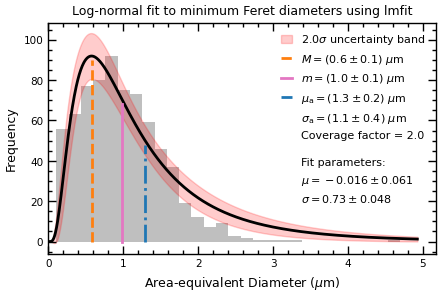

In [31]:
# Create plot
fig, ax = plt.subplots(figsize=(5, 3))

# Histogram, set density=True to normalize
n, bins, patches = ax.hist(data, bins='auto', density=normalize_histogram, facecolor = 'grey', alpha = 0.5, label=None)
centers = (0.5*(bins[1:]+bins[:-1]))

# Fit model using lmfit
model = models.LognormalModel()
params = model.make_params(center=1, sigma=1, amplitude=1)
#params['amplitude'].vary = False # Fix parameter

result = model.fit(n, params, x=centers)
print(result.fit_report())

# interpolated lmfit
xmin, xmax = ax.get_xlim()
x = np.linspace(xmin, xmax, 1000)
y_eval = model.eval(result.params, x=x)

ax.plot(x, y_eval, c='k')

# normal distribution, ~95% confidence level
coverage_factor = 2.0 

# confidence band, 95% sigma=2
dely = result.eval_uncertainty(x=x, params=result.params, sigma=coverage_factor)
ax.fill_between(x, y_eval-dely, y_eval+dely,
                color="red",
                alpha=0.2,
                label=rf'{coverage_factor}$\sigma$ uncertainty band')

# Add fit parameters (mu, sigma, mode) as labels
# Errors are from lmfit uvars
mu, sigma = result.uvars['center'], result.uvars['sigma']

muStar = exp(mu)
sigStar = exp(sigma)
confidence68 = (muStar/sigStar, muStar*sigStar) 
confidence95 = (muStar/sigStar**2, muStar*sigStar**2) 

mode = exp(mu - sigma ** 2)
median = exp(mu)
mean = exp(mu + sigma ** 2 / 2)
std = exp(mu + sigma**2/2) * sqrt(exp(sigma**2)-1)

print(f'Mode:\t\t {mode}')
print(f'Median:\t\t {median}')
print(f'Mean:\t\t {mean}')
print(f'Std. dev.:\t {std}')
print(f'Coverage factor:\t{coverage_factor}')
#print(f'68% conf. intervall: {np.round(confidence68[0].nominal_value)}+/-{np.round(confidence68[0].std_dev)} to {np.round(confidence68[1].nominal_value)}+/-{np.round(confidence68[1].std_dev)}')
#print(f'95% conf. intervall: {np.round(confidence95[0].nominal_value)}+/-{np.round(confidence95[0].std_dev)} to {np.round(confidence95[1].nominal_value)}+/-{np.round(confidence95[1].std_dev)}')

# Plot labels
lb_std = rf'$\sigma_\mathregular{{a}} = ({np.round(std.nominal_value,1)} \pm {np.round(coverage_factor*std.std_dev,1)})$ '+unit
lb_mean = rf'$\mu_\mathregular{{a}} = ({np.round(mean.nominal_value,1)} \pm {np.round(coverage_factor*mean.std_dev,1)})$ '+unit
lb_mode = rf'$M = ({np.round(mode.nominal_value,1)} \pm {np.round(coverage_factor*mode.std_dev,1)})$ '+unit
lb_median = rf'$m = ({np.round(median.nominal_value,1)} \pm {np.round(coverage_factor*median.std_dev,1)})$ '+unit
lb_mu = f'$\mu = {np.round(mu.nominal_value,3)} \pm {np.round(mu.std_dev,3)}$'
lb_sig = f'$\sigma = {np.round(sigma.nominal_value,3)} \pm {np.round(sigma.std_dev,3)}$'
lb_cov = f'Coverage factor = {coverage_factor}'

# Add vertical markers for positions of calculated properties
# Mode
ax.plot([mode.nominal_value, mode.nominal_value], [0, pdf(mode.nominal_value, *pars)*scaling_factor], c='tab:orange', ls='--', label=lb_mode)

# Median
ax.plot([median.nominal_value, median.nominal_value], [0, pdf(median.nominal_value, *pars)*scaling_factor], c='tab:pink', ls='-', label=lb_median)

# Mean
ax.plot([mean.nominal_value, mean.nominal_value], [0, pdf(mean.nominal_value, *pars)*scaling_factor], c='tab:blue', ls='-.', label=lb_mean)

# Gemerate empty plots, so that fit parameters are added in legend
plt.plot([], [], ' ', label=lb_std)
plt.plot([], [], ' ', label=lb_cov)
plt.plot([], [], ' ', label='\nFit parameters:')
plt.plot([], [], ' ', label=lb_mu)
plt.plot([], [], ' ', label=lb_sig)

# Cosmetics 
ax.set_title(f'Log-normal fit to minimum Feret diameters using lmfit', fontsize=9)
ax.set_xlabel('Area-equivalent Diameter ('+unit+')', fontsize=9)
ax.set_ylabel("Frequency", fontsize=9)
plt.tick_params(axis='both', which='major', labelsize=7.5)

ax.set_xlim(0,)

ax.legend(loc='best', handlelength=1, fontsize=8, ncol=1, columnspacing=0.1)

In [32]:
result.params

name,value,standard error,relative error,initial value,min,max,vary,expression
amplitude,126.880777,8.63215752,(6.80%),1.0,-inf,inf,True,
center,-0.01568140,0.06082410,(387.87%),1.0,-inf,inf,True,
sigma,0.73034153,0.04839926,(6.63%),1.0,0.00000000,inf,True,
height,91.9213324,5.39177371,(5.87%),0.24197072451914337,-inf,inf,False,"amplitude/max(1e-15, (sigma*sqrt(2*pi)))*exp(sigma**2/2-center)"
fwhm,1.12016938,0.07626482,(6.81%),2.9378807375885114,-inf,inf,False,exp(center-sigma**2+sigma*sqrt(2*log(2)))-exp(center-sigma**2-sigma*sqrt(2*log(2)))


# Fit with uncertainties on histogram bars (assuming Poisson)
Here we assume a Poisson distribution with uncertainties $\sqrt{n}$ on each bin (don't know if this assumption is valid for particle size analysis... This is mainly for testing).  
We set `weights=1/yerr` to include them in the model fit.

In [33]:
model = models.LognormalModel()

[[Model]]
    Model(lognormal)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 135
    # data points      = 28
    # variables        = 3
    chi-square         = 75.4794686
    reduced chi-square = 3.01917875
    Akaike info crit   = 33.7663728
    Bayesian info crit = 37.7629863
    R-squared          = 0.86533604
[[Variables]]
    amplitude:  106.012717 +/- 7.41760861 (7.00%) (init = 1)
    center:    -0.13730876 +/- 0.04260288 (31.03%) (init = 1)
    sigma:      0.56970706 +/- 0.03448435 (6.05%) (init = 1)
    height:     100.167655 +/- 8.40815047 (8.39%) == 'amplitude/max(1e-15, (sigma*sqrt(2*pi)))*exp(sigma**2/2-center)'
    fwhm:       0.91014942 +/- 0.04301487 (4.73%) == 'exp(center-sigma**2+sigma*sqrt(2*log(2)))-exp(center-sigma**2-sigma*sqrt(2*log(2)))'
[[Correlations]] (unreported correlations are < 0.100)
    C(center, sigma) = -0.1893
Mode:		 0.63+/-0.04
Median:		 0.87+/-0.04
Mean:		 1.03+/-0.04
Std. dev.:	 0.63+/-0.06
Coverage factor:	2.0


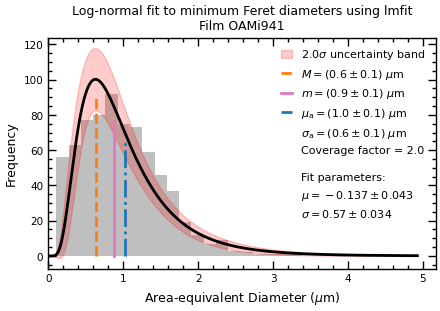

In [41]:
# Create plot
fig, ax = plt.subplots(figsize=(5, 3))

# Histogram, set density=True to normalize
n, bins, patches = ax.hist(data, bins='auto', density=False, facecolor = 'grey', alpha = 0.5, label=None)
centers = (0.5*(bins[1:]+bins[:-1]))

# Fit model using lmfit
model = models.LognormalModel()
params = model.make_params(center=1, sigma=1, amplitude=1)

# Calculate uncertainties on y values of histogram, here assuming Poisson distribution
# add +1 to histogram data to avoid inf/NaN
yerr = np.sqrt(n+1)

result = model.fit(n, params, x=centers, weights=1/yerr)
print(result.fit_report())

# interpolated lmfit
xmin, xmax = ax.get_xlim()
x = np.linspace(xmin, xmax, 1000)
y_eval = model.eval(result.params, x=x)

ax.plot(x, y_eval, c='k')

# normal distribution, ~95% confidence level
coverage_factor = 2.0 

# confidence band, 95% sigma=2
dely = result.eval_uncertainty(x=x, params=result.params, sigma=coverage_factor)
ax.fill_between(x, y_eval-dely, y_eval+dely,
                color="red",
                alpha=0.2,
                label=rf'{coverage_factor}$\sigma$ uncertainty band')

# Add fit parameters (mu, sigma, mode) as labels
# Errors are from lmfit uvars
mu, sigma = result.uvars['center'], result.uvars['sigma']

muStar = exp(mu)
sigStar = exp(sigma)
confidence68 = (muStar/sigStar, muStar*sigStar) 
confidence95 = (muStar/sigStar**2, muStar*sigStar**2) 

mode = exp(mu - sigma ** 2)
median = exp(mu)
mean = exp(mu + sigma ** 2 / 2)
std = exp(mu + sigma**2/2) * sqrt(exp(sigma**2)-1)

print(f'Mode:\t\t {mode}')
print(f'Median:\t\t {median}')
print(f'Mean:\t\t {mean}')
print(f'Std. dev.:\t {std}')
print(f'Coverage factor:\t{coverage_factor}')
#print(f'68% conf. intervall: {np.round(confidence68[0].nominal_value)}+/-{np.round(confidence68[0].std_dev)} to {np.round(confidence68[1].nominal_value)}+/-{np.round(confidence68[1].std_dev)}')
#print(f'95% conf. intervall: {np.round(confidence95[0].nominal_value)}+/-{np.round(confidence95[0].std_dev)} to {np.round(confidence95[1].nominal_value)}+/-{np.round(confidence95[1].std_dev)}')

# Plot labels
lb_std = rf'$\sigma_\mathregular{{a}} = ({np.round(std.nominal_value,1)} \pm {np.round(coverage_factor*std.std_dev,1)})$ '+unit
lb_mean = rf'$\mu_\mathregular{{a}} = ({np.round(mean.nominal_value,1)} \pm {np.round(coverage_factor*mean.std_dev,1)})$ '+unit
lb_mode = rf'$M = ({np.round(mode.nominal_value,1)} \pm {np.round(coverage_factor*mode.std_dev,1)})$ '+unit
lb_median = rf'$m = ({np.round(median.nominal_value,1)} \pm {np.round(coverage_factor*median.std_dev,1)})$ '+unit
lb_mu = f'$\mu = {np.round(mu.nominal_value,3)} \pm {np.round(mu.std_dev,3)}$'
lb_sig = f'$\sigma = {np.round(sigma.nominal_value,3)} \pm {np.round(sigma.std_dev,3)}$'
lb_cov = f'Coverage factor = {coverage_factor}'

# Add vertical markers for positions of calculated properties
# Mode
ax.plot([mode.nominal_value, mode.nominal_value], [0, pdf(mode.nominal_value, *pars)*scaling_factor], c='tab:orange', ls='--', label=lb_mode)

# Median
ax.plot([median.nominal_value, median.nominal_value], [0, pdf(median.nominal_value, *pars)*scaling_factor], c='tab:pink', ls='-', label=lb_median)

# Mean
ax.plot([mean.nominal_value, mean.nominal_value], [0, pdf(mean.nominal_value, *pars)*scaling_factor], c='tab:blue', ls='-.', label=lb_mean)

# Gemerate empty plots, so that fit parameters are added in legend
plt.plot([], [], ' ', label=lb_std)
plt.plot([], [], ' ', label=lb_cov)
plt.plot([], [], ' ', label='\nFit parameters:')
plt.plot([], [], ' ', label=lb_mu)
plt.plot([], [], ' ', label=lb_sig)

# Cosmetics 
ax.set_title(f'Log-normal fit to minimum Feret diameters using lmfit\n'+titre, fontsize=9)
ax.set_xlabel('Area-equivalent Diameter ('+unit+')', fontsize=9)
ax.set_ylabel("Frequency", fontsize=9)
plt.tick_params(axis='both', which='major', labelsize=7.5)

ax.set_xlim(0,)

ax.legend(loc='best', handlelength=1, fontsize=8, ncol=1, columnspacing=0.1)

In [42]:
result.params

name,value,standard error,relative error,initial value,min,max,vary,expression
amplitude,106.012717,7.41760861,(7.00%),1.0,-inf,inf,True,
center,-0.13730876,0.04260288,(31.03%),1.0,-inf,inf,True,
sigma,0.56970706,0.03448435,(6.05%),1.0,0.00000000,inf,True,
height,100.167655,8.40815047,(8.39%),0.24197072451914337,-inf,inf,False,"amplitude/max(1e-15, (sigma*sqrt(2*pi)))*exp(sigma**2/2-center)"
fwhm,0.91014942,0.04301487,(4.73%),2.9378807375885114,-inf,inf,False,exp(center-sigma**2+sigma*sqrt(2*log(2)))-exp(center-sigma**2-sigma*sqrt(2*log(2)))


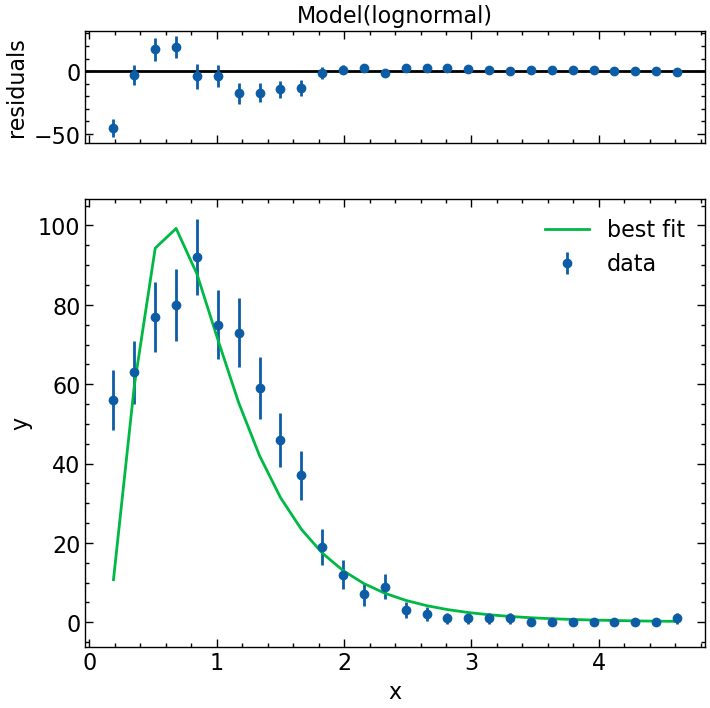

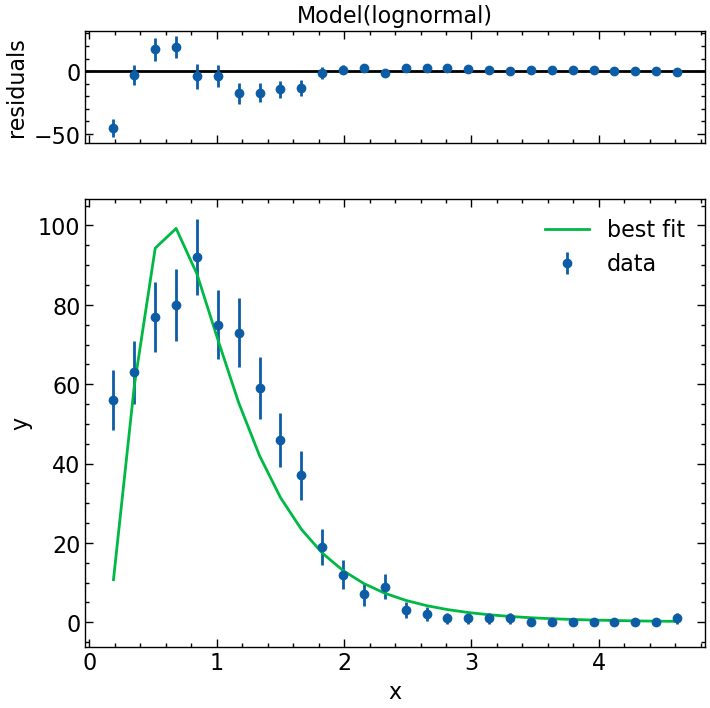

In [43]:
result.plot(yerr = yerr)

# Combine with discrete CDF

In [44]:
model = models.LognormalModel()

In [45]:
def ecdf(a):
    x, counts = np.unique(a, return_counts=True)
    cusum = np.cumsum(counts)
    return x, cusum / cusum[-1]

In [46]:
def add_d_value_marker(y, x, d, axs=plt.gca(), **kwargs):
    idx = (np.abs(y-d)).argmin()+1
    dp = int(d*100)
    axs.vlines(x=x[idx], ymin=0, ymax=d, **kwargs)
    axs.hlines(y=d, xmin=x[idx], xmax=axs.get_xlim()[1], **kwargs)
    axs.text(x=0.98*axs.get_xlim()[1], y=y[idx]+0.01*axs.get_ylim()[1], s=f'$d_{{{dp}}}$ = {np.round(x[idx],1)} $\mu$m', va='baseline', ha='right', fontsize=8)
    return y[idx], x[idx], idx 

[[Model]]
    Model(lognormal)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 82
    # data points      = 28
    # variables        = 3
    chi-square         = 2454.96001
    reduced chi-square = 98.1984004
    Akaike info crit   = 131.262515
    Bayesian info crit = 135.259128
    R-squared          = 0.91298468
[[Variables]]
    amplitude:  126.880777 +/- 8.63215752 (6.80%) (init = 1)
    center:    -0.01568140 +/- 0.06082410 (387.87%) (init = 1)
    sigma:      0.73034153 +/- 0.04839926 (6.63%) (init = 1)
    height:     91.9213324 +/- 5.39177371 (5.87%) == 'amplitude/max(1e-15, (sigma*sqrt(2*pi)))*exp(sigma**2/2-center)'
    fwhm:       1.12016938 +/- 0.07626482 (6.81%) == 'exp(center-sigma**2+sigma*sqrt(2*log(2)))-exp(center-sigma**2-sigma*sqrt(2*log(2)))'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, center) = +0.6607
    C(amplitude, sigma)  = +0.6238
    C(center, sigma)     = +0.5979
Mode:		 0.577+/-0.034
Median:		 0.98+

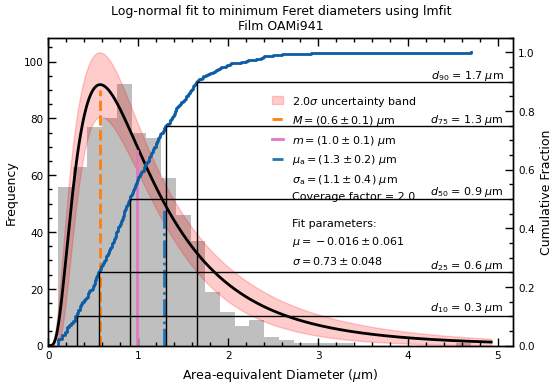

In [48]:
# Create plot
fig, ax = plt.subplots(figsize=(6, 4))

# Histogram, set density=True to normalize
n, bins, patches = ax.hist(data, bins='auto', density=normalize_histogram, facecolor = 'grey', alpha = 0.5, label=None)
centers = (0.5*(bins[1:]+bins[:-1]))

# Fit model using lmfit
model = models.LognormalModel()
params = model.make_params(center=1, sigma=1, amplitude=1)
#params['amplitude'].vary = False # Fix parameter

result = model.fit(n, params, x=centers)
print(result.fit_report())

# interpolated lmfit
xmin, xmax = ax.get_xlim()
x = np.linspace(xmin, xmax, 1000)
y_eval = model.eval(result.params, x=x)

ax.plot(x, y_eval, c='k')

# normal distribution, ~95% confidence level
coverage_factor = 2.0 

# confidence band, 95% sigma=2
dely = result.eval_uncertainty(x=x, params=result.params, sigma=coverage_factor)
ax.fill_between(x, y_eval-dely, y_eval+dely,
                color="red",
                alpha=0.2,
                label=rf'{coverage_factor}$\sigma$ uncertainty band')

# Plot CDF
ax1 = ax.twinx()
x1, y1 = ecdf(data)
x1 = np.insert(x1, 0, x1[0])
y1 = np.insert(y1, 0, 0.)
ax1.plot(x1, y1, drawstyle='steps-post')


# Add fit parameters (mu, sigma, mode) as labels
# Errors are from lmfit uvars
mu, sigma = result.uvars['center'], result.uvars['sigma']

muStar = exp(mu)
sigStar = exp(sigma)
confidence68 = (muStar/sigStar, muStar*sigStar) 
confidence95 = (muStar/sigStar**2, muStar*sigStar**2) 

mode = exp(mu - sigma ** 2)
median = exp(mu)
mean = exp(mu + sigma ** 2 / 2)
std = exp(mu + sigma**2/2) * sqrt(exp(sigma**2)-1)

print(f'Mode:\t\t {mode}')
print(f'Median:\t\t {median}')
print(f'Mean:\t\t {mean}')
print(f'Std. dev.:\t {std}')
print(f'Coverage factor:\t{coverage_factor}')
#print(f'68% conf. intervall: {np.round(confidence68[0].nominal_value)}+/-{np.round(confidence68[0].std_dev)} to {np.round(confidence68[1].nominal_value)}+/-{np.round(confidence68[1].std_dev)}')
#print(f'95% conf. intervall: {np.round(confidence95[0].nominal_value)}+/-{np.round(confidence95[0].std_dev)} to {np.round(confidence95[1].nominal_value)}+/-{np.round(confidence95[1].std_dev)}')

# Plot labels
lb_std = rf'$\sigma_\mathregular{{a}} = ({np.round(std.nominal_value,1)} \pm {np.round(coverage_factor*std.std_dev,1)})$ $\mu$m'
lb_mean = rf'$\mu_\mathregular{{a}} = ({np.round(mean.nominal_value,1)} \pm {np.round(coverage_factor*mean.std_dev,1)})$ $\mu$m'
lb_mode = rf'$M = ({np.round(mode.nominal_value,1)} \pm {np.round(coverage_factor*mode.std_dev,1)})$ $\mu$m'
lb_median = rf'$m = ({np.round(median.nominal_value,1)} \pm {np.round(coverage_factor*median.std_dev,1)})$ $\mu$m'
lb_mu = f'$\mu = {np.round(mu.nominal_value,3)} \pm {np.round(mu.std_dev,3)}$'
lb_sig = f'$\sigma = {np.round(sigma.nominal_value,3)} \pm {np.round(sigma.std_dev,3)}$'
lb_cov = f'Coverage factor = {coverage_factor}'

# Add vertical markers for positions of calculated properties
# Mode
ax.plot([mode.nominal_value, mode.nominal_value], [0, pdf(mode.nominal_value, *pars)*scaling_factor], c='tab:orange', ls='--', label=lb_mode)

# Median
ax.plot([median.nominal_value, median.nominal_value], [0, pdf(median.nominal_value, *pars)*scaling_factor], c='tab:pink', ls='-', label=lb_median)

# Mean
ax.plot([mean.nominal_value, mean.nominal_value], [0, pdf(mean.nominal_value, *pars)*scaling_factor], c='tab:blue', ls='-.', label=lb_mean)

# Gemerate empty plots, so that fit parameters are added in legend
ax.plot([], [], ' ', label=lb_std)
ax.plot([], [], ' ', label=lb_cov)
ax.plot([], [], ' ', label='\nFit parameters:')
ax.plot([], [], ' ', label=lb_mu)
ax.plot([], [], ' ', label=lb_sig)

# Cosmetics 
ax.set_title(f'Log-normal fit to minimum Feret diameters using lmfit\n'+titre, fontsize=9)
ax.set_xlabel('Area-equivalent Diameter ('+unit+')', fontsize=9)
ax.set_ylabel("Frequency", fontsize=9)
ax1.set_ylabel("Cumulative Fraction", fontsize=9)
ax.tick_params(axis='both', which='major', labelsize=7.5)
ax1.tick_params(axis='both', which='major', labelsize=7.5)

ax.set_xlim(0,)
ax.set_ylim(0,)
ax1.set_ylim(0,)
#
# c'est ici que l'on ajoute des valeurs dans le plot
#
add_d_value_marker(y1, x1, d=0.9, axs=ax1, color='k', lw=1.0)
add_d_value_marker(y1, x1, d=0.75, axs=ax1, color='k', lw=1.0)
add_d_value_marker(y1, x1, d=0.5, axs=ax1, color='k', lw=1.0)
add_d_value_marker(y1, x1, d=0.25, axs=ax1, color='k', lw=1.0)
add_d_value_marker(y1, x1, d=0.1, axs=ax1, color='k', lw=1.0)

ax.legend(loc='upper left', 
          handlelength=1, 
          fontsize=8, 
          ncol=1, 
          columnspacing=0.1,
          bbox_to_anchor=(0.46, 0.85),
          mode='expand'
         )

fig.savefig('plots/Area-equivalentDiameter_lmfit_cdf.svg', pad_inches=0)
fig.savefig('plots/Area-equivalentDiameter_lmfit_cdf.png', dpi=600, pad_inches=0)